In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*(x**2) + 2*x

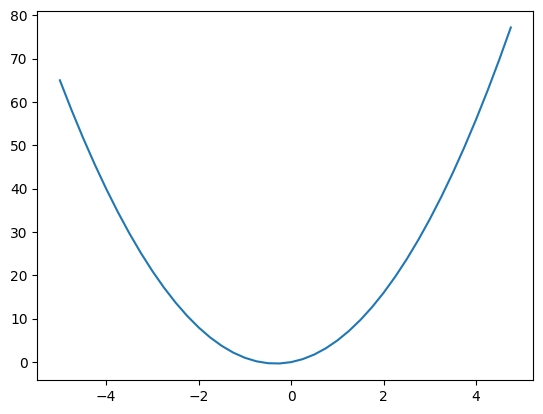

In [3]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [4]:
def diff(f, x):
    h = 0.001
    return (f(x+h)-f(x)) / h

# for h -> 0: diff -> 0
diff(f, -1/3)

0.0029999999999752447

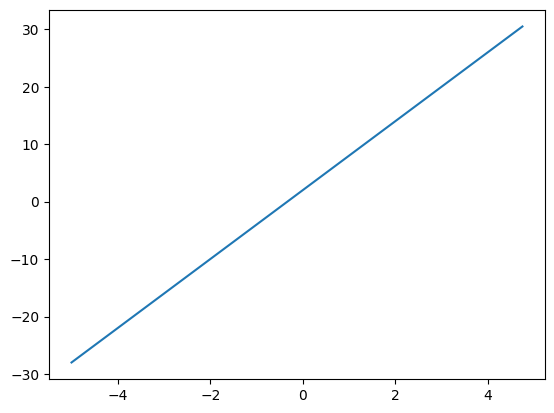

In [5]:
d_ys = diff(f, xs)
plt.plot(xs, d_ys)

In [88]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [63]:
# computational sequence builds a graph
a = Value(2, label='a')
b = Value(5, label='b')
c = a * b; c.label='c'
d = c * a; d.label='d'
e = Value(3, label='e')
L = d + e; L.label='L'
O = L.tanh(); O.label='O'

In [64]:
# populate graph for visualization

from graphviz import Digraph

def trace(root):
  # recursive dfs on the tree structure created by Value() instances nested in Value()._prev attribute, which is a set
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

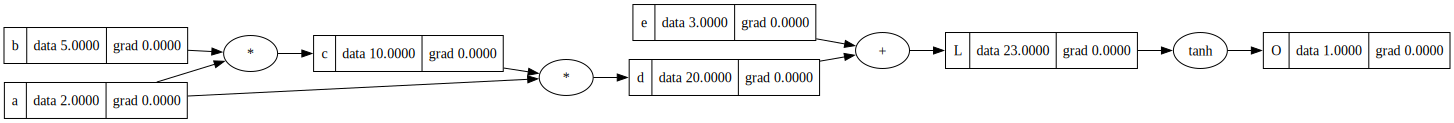

In [65]:
draw_dot(O)

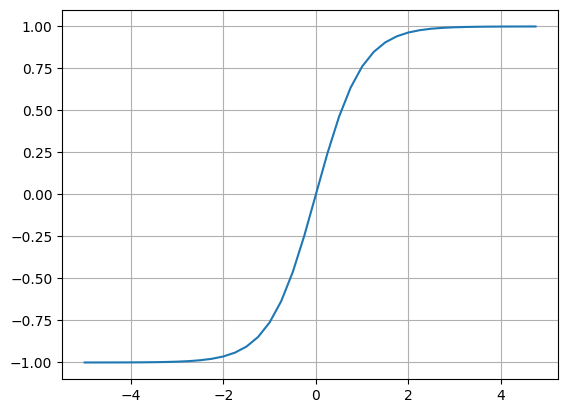

In [66]:
plt.plot(np.arange(-5,5,0.25), np.tanh(np.arange(-5,5,0.25))); plt.grid();

In [67]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

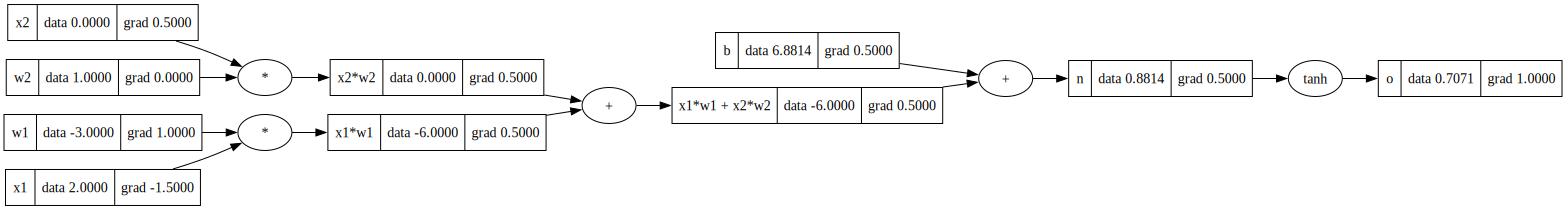

In [70]:
draw_dot(o)

Use topological sorted graph for calling _backward

In [69]:
o.backward()

Manually calling _backward method

In [73]:
o.grad = 1
# _backward on a leaf node returns None by default

In [74]:
o._backward()

In [76]:
n._backward()

In [78]:
x1w1x2w2._backward()

In [80]:
x1w1._backward()
x2w2._backward()

Derivative of $L$ w.r.t node $c$ 
for manual backpropagation

$dL/dc = (dL/dd) * (dd/dc)$

Manually computing gradients with chain rule / heuristics

In [44]:
# o = tanh(n)
# do/dn = 1-tanh(n)**2
n.grad = 1 - o.data**2

In [45]:
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [46]:
x2w2.grad = 0.5
x1w1.grad = 0.5

In [48]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

In [22]:
import torch

In [23]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [154]:
# takes in instances of Value(), calculates weighted biased sum, outputs an instance of Value()

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        act = sum([wi * xi for wi, xi in zip(self.w, x)], self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    # nin: random weights to initialise for processing previous layer outputs
    # nout: neurons in the layer
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:
    def __init__(self, nin: int, nout: list):
        sz = [nin] + nout
        self.layers = [Layer(sz[i-1], sz[i]) for i in range(1, len(sz))]

    def __call__(self, x):
        # iterate through layers and using the past output as new input
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [165]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [166]:
mlp = MLP(3, [4, 4, 1])

In [167]:
epoch = 60

for i in range(epoch):

    # forward pass
    ypred = [mlp(x) for x in xs]
    loss = sum((yhat - y)**2 for yhat, y in zip(ypred, ys))

    # backward pass
    for p in mlp.parameters():
        p.grad = 0
    loss.backward()

    # gradient descent
    for p in mlp.parameters():
        p.data += -0.05 * p.grad

    print(i, loss.data)


special_neuron = mlp.layers[0].neurons[0]
print(f'Special neuron Weights: \n {[wi.data for wi in special_neuron.w]} \n Special Neuron Grad: \n {[wi.grad for wi in special_neuron.w]}')
print(f' Predicted output: \n {ypred}')
print(f'Loss: \n {loss}')

0 3.8767770627241385
1 0.5086259455329183
2 0.21558288729985503
3 0.16387449609900243
4 0.13398720628654476
5 0.11352500974488308
6 0.09845310123198733
7 0.08685314289757211
8 0.07764440332859097
9 0.07015844886216131
10 0.06395609278203555
11 0.058735869902396265
12 0.05428369729558644
13 0.050443289975147146
14 0.047097889448306174
15 0.04415852738639596
16 0.041556239747226574
17 0.03923675881164852
18 0.03715680842012615
19 0.03528146442425782
Special neuron Weights: 
 [-1.237786818931577, 0.4116046554613562, 0.011754418965161769] 
 Special Neuron Grad: 
 [-0.0010610724288018722, -0.002775841208892465, -0.004937147327491885]
 Predicted output: 
 [Value(data=0.9148046356926508), Value(data=-0.8842234746156499), Value(data=-0.9434544660215207), Value(data=0.8931280528772333)]
Loss: 
 Value(data=0.03528146442425782)


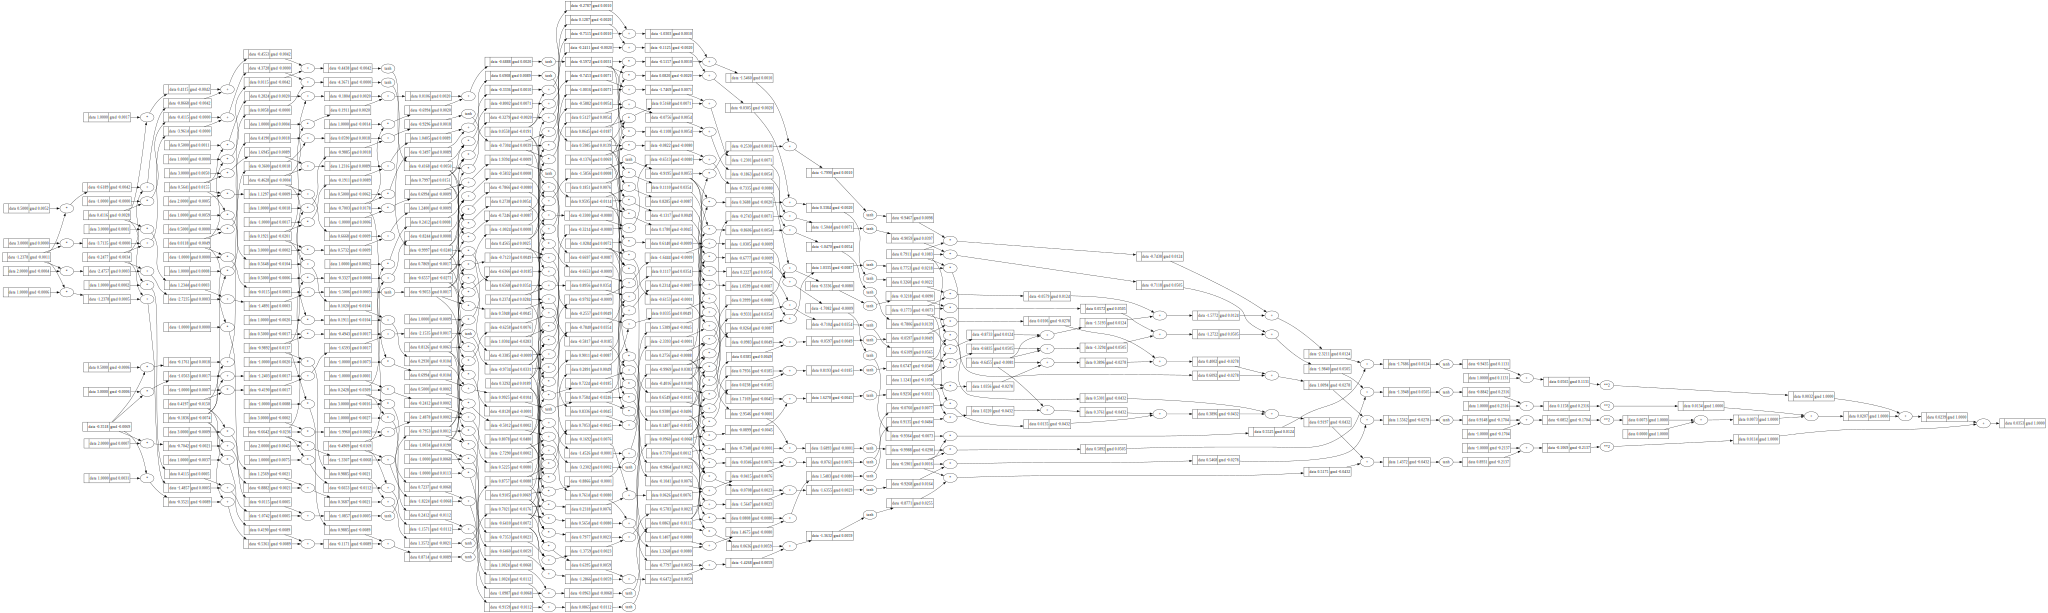

In [168]:
draw_dot(loss)